In [123]:
import re
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit
import random
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt
import sklearn_evaluation.plot.grid_search
import matplotlib
%matplotlib inline

In [70]:
import warnings
warnings.filterwarnings('ignore')

In [144]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=6)
    ax.grid('on')

In [ ]:
def grid_plot(x, y, x_label, title, y_label='accuracy'):
    plt.figure(figsize=(12, 6))
    plt.grid(True),
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

# CONTEST 1


# Import Data

In [7]:
data = pd.read_csv('train.csv')
data.drop('id', axis = 1, inplace = True)
X_train = np.asarray(data[data.columns[range(1, data.shape[1])]], dtype = np.double)
Y_train = np.asarray(data[['label']], dtype = np.double).ravel()
X_train_scaled = scale(X_train)
data.head()

,label,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat207,feat208,feat209,feat210,feat211,feat212,feat213,feat214,feat215,feat216
0,1,7,0,3,0,2,3,0,6,0,...,3,4,2,2,0,13,0,11,1,3
1,1,0,11,0,0,10,1,0,0,4,...,0,2,0,0,2,8,1,13,0,4
2,0,9,0,3,0,1,3,0,4,0,...,48,11,2,0,0,4,0,2,0,0
3,0,0,9,3,2,25,0,4,0,0,...,1,14,1,0,0,0,3,0,17,1
4,0,0,0,0,0,2,5,0,0,0,...,3,12,0,3,0,4,0,24,4,0


In [8]:
data.groupby(['label']).count()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat207,feat208,feat209,feat210,feat211,feat212,feat213,feat214,feat215,feat216
label,,,,,,,,,,,,,,,,,,,,,
0,327,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,327,327,327
1,573,573,573,573,573,573,573,573,573,573,...,573,573,573,573,573,573,573,573,573,573


In [9]:
test = pd.read_csv('test.csv')
X_test = np.asarray(test[test.columns[range(1, test.shape[1])]])
X_test_scaled = scale(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


# Fit Methods

In [5]:
estimators = [
    SGDClassifier(max_iter=5000, tol=0.1, penalty='l1', alpha=0.1),
    SVC(kernel='rbf', C = 0.1, gamma=2),
    LinearSVC(penalty = 'l2', dual=False), 
    LogisticRegression(penalty='l1', C=0.2),
]

In [6]:
cv_strategy = ShuffleSplit(n_splits=10, test_size=0.2, random_state=33)
for estimator in estimators:
    %time scoring = cross_val_score(estimator, X_train, Y_train, scoring='roc_auc', cv=cv_strategy)
    print ('%s %.3lf' % (str(estimator).replace('(',' ').split()[0], scoring.mean()), '%.4lf' % scoring.std())

CPU times: user 449 ms, sys: 23.6 ms, total: 472 ms
Wall time: 539 ms
SGDClassifier 0.843 0.0288
CPU times: user 1.51 s, sys: 10.3 ms, total: 1.52 s
Wall time: 1.54 s
SVC 0.877 0.0171
CPU times: user 4.1 s, sys: 16.1 ms, total: 4.12 s
Wall time: 4.13 s
LinearSVC 0.913 0.0149
CPU times: user 594 ms, sys: 1.69 ms, total: 595 ms
Wall time: 594 ms
LogisticRegression 0.923 0.0189


Видим, что LogisticRegression дает лучший score на кросс-валидации. Попробуем подобрать гиперпараметры для нее.

# GridSearchCV для LogisticRegression

In [119]:
hyperparameters = {'penalty': ['l1', 'l2'],
                   'C': list(np.arange(0.1, 10.1, 0.5))}
estimator = LogisticRegression(n_jobs=-1, random_state=random.randint(1, 100))
clf = GridSearchCV(estimator, hyperparameters, scoring='roc_auc', cv=5)
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=31, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1, 5.6, 6.1, 6.6, 7.1, 7.6, 8.1, 8.6, 9.1, 9.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [120]:
clf.best_params_, clf.best_score_

({'C': 0.6, 'penalty': 'l1'}, 0.9329200969384035)

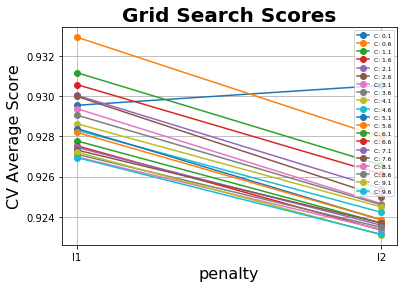

In [145]:
plot_grid_search(clf.cv_results_, ['l1', 'l2'], list(np.arange(0.1, 10.1, 0.5)), 'penalty', 'C')
plt.figure(figsize=(15,9))
plt.show()

In [148]:
hyperparameters = {'penalty': ['l1', 'l2'],
                   'C': list(np.arange(0.4, 0.7, 0.01))}
estimator = LogisticRegression(n_jobs=-1, random_state=random.randint(1, 100))
clf = GridSearchCV(estimator, hyperparameters, scoring='roc_auc', cv=5)
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=8, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.4, 0.41000000000000003, 0.42000000000000004, 0.43000000000000005, 0.44000000000000006, 0.45000000000000007, 0.4600000000000001, 0.4700000000000001, 0.4800000000000001, 0.4900000000000001, 0.5000000000000001, 0.5100000000000001, 0.5200000000000001, 0.53000...0.6500000000000002, 0.6600000000000003, 0.6700000000000003, 0.6800000000000003, 0.6900000000000003]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

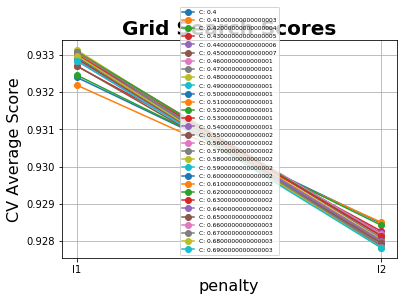

In [149]:
plot_grid_search(clf.cv_results_, hyperparameters['penalty'], hyperparameters['C'], 'penalty', 'C')

In [150]:
clf.best_params_, clf.best_score_

({'C': 0.4800000000000001, 'penalty': 'l1'}, 0.9331272544727921)

Далее оказалось, что ни одна из моих submission, в которых я пыталась настроить именно LogisticRegression, не заходит на Private. Что показалось мне странным, учитывая, что на кросс-валидации средний score у нее около ~0.93. 
Поэтому дальше я попыталась настроить другую линейную модель: я начала с SVC (и как же хорошо, что ей все-таки удалось пройти benchmark'и).

# GridSearchCV для SVC (и решение, которое проходит оба benchmark'a)

In [151]:
hyperparameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                   'C': list(np.arange(0.1, 10.1, 0.5)),
                  }
estimator = SVC()

In [152]:
clf = GridSearchCV(estimator, hyperparameters, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1, 5.6, 6.1, 6.6, 7.1, 7.6, 8.1, 8.6, 9.1, 9.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [153]:
clf.best_params_, clf.best_score_

({'C': 7.6, 'kernel': 'rbf'}, 0.9782566384374165)

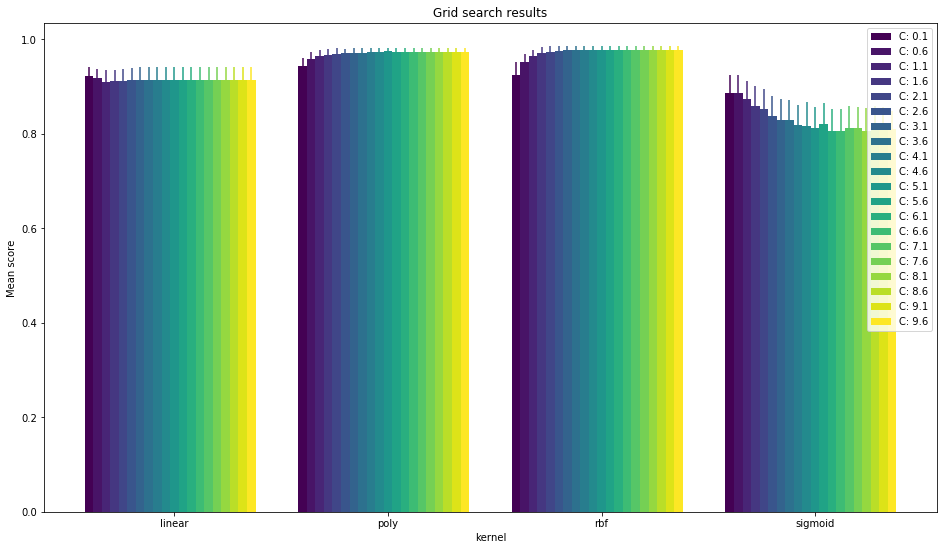

In [154]:
plt.figure(num=None, figsize=(16, 9))
sklearn_evaluation.plot.grid_search(clf.grid_scores_, change='kernel', kind='bar')

In [155]:
hyperparameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                   'C': list(np.arange(7, 8, 0.2))}

In [156]:
clf = GridSearchCV(estimator, hyperparameters, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [7.0, 7.2, 7.4, 7.6000000000000005, 7.800000000000001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [157]:
clf.best_params_, clf.best_score_

({'C': 7.6000000000000005, 'kernel': 'rbf'}, 0.9782566384374165)

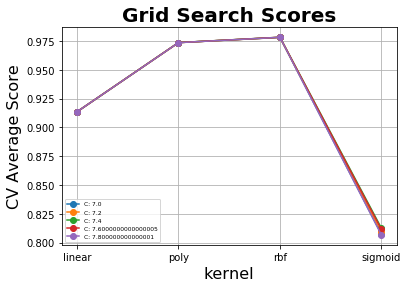

In [158]:
plot_grid_search(clf.cv_results_, ['linear', 'poly', 'rbf', 'sigmoid'], list(np.arange(7, 8, 0.2)), 'kernel', 'C')

In [159]:
predictions = clf.predict(X_test_scaled)
test['label'] = predictions.astype(int)
test[['id', 'label']].to_csv('attempt17.csv', sep = ',', index = False)